In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\begin{split}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1]).
	\end{split}
	\label{poisson2d:laplace}
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

In [178]:
def poisson_square(a,b,c,d,f,g,n):
    """Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:
        
        u_xx + u_yy = f on R = [a,b]×[c,d]
        u = g on ∂R
    
    where (b-a) = (d-c).
        
    Parameters:
        a (float): left-hand boundary for x
        b (float): right-hand boundary for x
        c (float): lower boundary for y
        d (float): uppder boundary for y
        f (function): right-hand side of the PDE
        g (function): boundary condition
        n (int): number of subintervals
    Returns:
        U (ndarray of shape (n+1,n+1)): approximate solution
    """
    #from equation 13.4: need to 1st find A, q and p
    
    #first get all components need to make matrix A:
    x, h = np.linspace(a, b, n+1, retstep = True) #retstep gives you the space btw each pts so that's how able to get h
    y = np.linspace(c, d, n+1)
    
    #make matrix T using scipy.sparse.diags:
    I = sp.diags([1,1],[-n+1,n-1], shape = ((n-1)**2, (n-1)**2)).toarray() #the offsets are -n+1 and n-1 bc of how T is set up, shape is squared to account for rows and columns both
    T = sp.diags([1, -4, 1], [-1, 0, 1], shape = (n-1, n-1)).toarray()  #make with the diagonals and the offsets
    
    #now have everything need to make A:
    
    #construct matrix by 1st making matrix w/ T's on diagonal and then add the matrix with the 1's on the offset diagonals
    #do [T]*(n-1) so that have correct amount of n-1 T's
    A = (1/h**2)*(sp.block_diag([T]*(n-1)) + I)
    
    #make p vector:
    p_vecs = []             #list where store each individual p vector that have
    for j in range(n-1):    #make each individual p vector itself
        p = np.zeros(n-1)
        p[0] = g(x[0], y[j])
        p[-1] = g(x[n], y[j])
        p_vecs.append((1/h**2)*p)
    whole_p_vec = np.concatenate(p_vecs)
    
    #make q vector: use matrix like approach where then flatten it
    q = np.zeros((n-1, n-1))
    q[0] = 1/h**2
    q[-1] = 1/h**2
    for i in range(n-1):    #get the first and last q vectors
        q[0, i] = 1/h**2 * g(x[i+1], y[0])
        q[-1, i] = 1/h**2 * g(x[i+1], y[-1])
    q[1:-2] = np.zeros(n-1) #get all of the q's in between
    q = q.flatten()         #flatten it to make it a vector

    #make the f array: use the same matrix like approach that used for q
    f_array = np.ones((n-1, n-1))  
    for i in range(n-1):
        for j in range(n-1):
            f_array[i,j] = f(x[j], y[i])  #get each f^j in lab manual
    f_array = f_array.flatten()           #need to flatten it
    
    U = spla.spsolve(A, f_array-whole_p_vec-q) #have AU+p+q = f and want to solve for U using scipy.sparse.linalg
    
    return U


In [179]:
a = 0
b = 1
c = 0
d = 1
f = lambda x, y: 0
g = lambda x, y: x**3
n = 100

U = poisson_square(a,b,c,d,f,g,n)
print("The solution is: ")
print(U)

The solution is: 
[2.31797350e-04 4.69529038e-04 7.19129336e-04 ... 9.16148994e-01
 9.43730159e-01 9.71718046e-01]


<IPython.core.display.Javascript object>


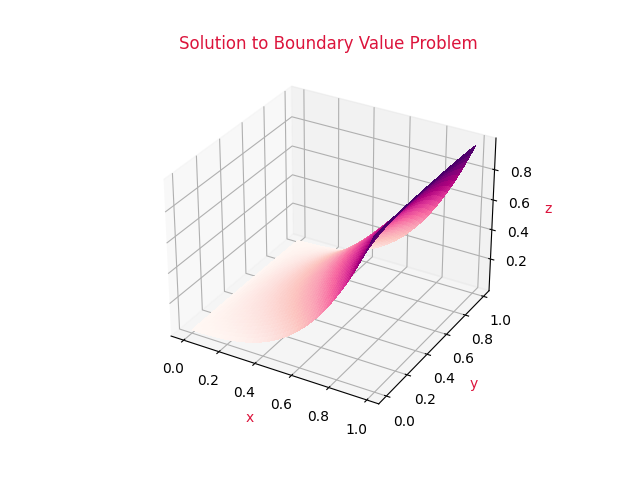

In [156]:
#plot solution as 3D surface:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

X = np.arange(a, b, 1/(n-1))  #1/(n-1) is the step size
Y = np.arange(c, d, 1/(n-1))
X, Y = np.meshgrid(X, Y)      #need a meshgrid to make 3D plots
Z = U.reshape((n-1), (n-1))   #then make Z

surface_ting = ax.plot_surface(X, Y, Z, cmap = "RdPu", linewidth = 0, antialiased = False)
plt.title("Solution to Boundary Value Problem", color = "crimson")
ax.set_xlabel("x", color = "crimson")
ax.set_ylabel("y", color = "crimson")
ax.set_zlabel("z", color = "crimson")

plt.show()

# Problem 2

Solve 

\begin{align}
	\begin{split}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
	\end{split}
	\label{poisson2d:source}
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

<IPython.core.display.Javascript object>


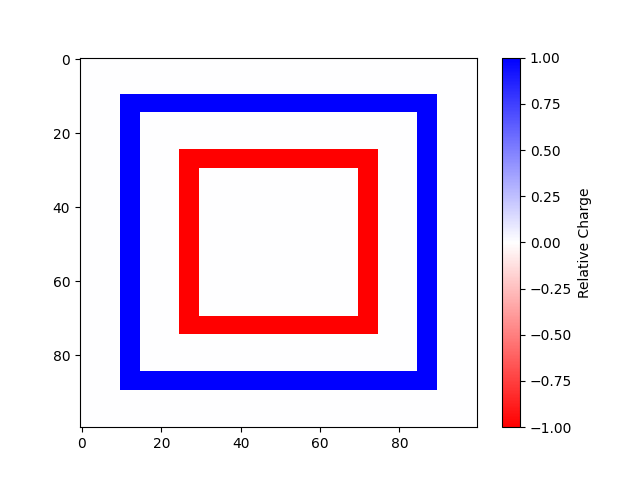

In [157]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

plt.imshow(source(X,Y), aspect = 'auto', cmap = mcolors.LinearSegmentedColormap('cmap', genDict(source(X,Y))))
plt.colorbar(label="Relative Charge")
plt.show()

In [172]:
a2, b2, c2, d2 = -2, 2, -2, 2
g2 = lambda x, y: 0
n2 = 100
f2 = lambda x, y: -source(x, y)

U2 = poisson_square(a2,b2,c2,d2,f2,g2,n2)
print("The solution here is: ")
print(U2)

The solution here is: 
[0.00011219 0.00022438 0.00033651 ... 0.00044743 0.00029837 0.00014919]


<IPython.core.display.Javascript object>


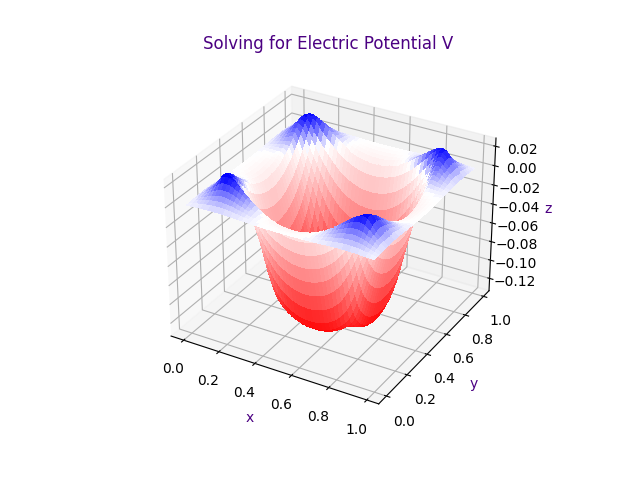

In [173]:
#plot solution as 3D surface:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})

X = np.arange(a, b, 1/(n-1))  #1/(n-1) is the step size
Y = np.arange(c, d, 1/(n-1))
X, Y = np.meshgrid(X, Y)      #need a meshgrid to make 3D plots
Z = U2.reshape((n-1), (n-1))   #then make Z

surface_ting = ax.plot_surface(X, Y, Z, cmap = mcolors.LinearSegmentedColormap('cmap', genDict(Z)), linewidth = 0, antialiased = False)
plt.title("Solving for Electric Potential V", color = "indigo")
ax.set_xlabel("x", color = "indigo")
ax.set_ylabel("y", color = "indigo")
ax.set_zlabel("z", color = "indigo")

plt.show()

<IPython.core.display.Javascript object>


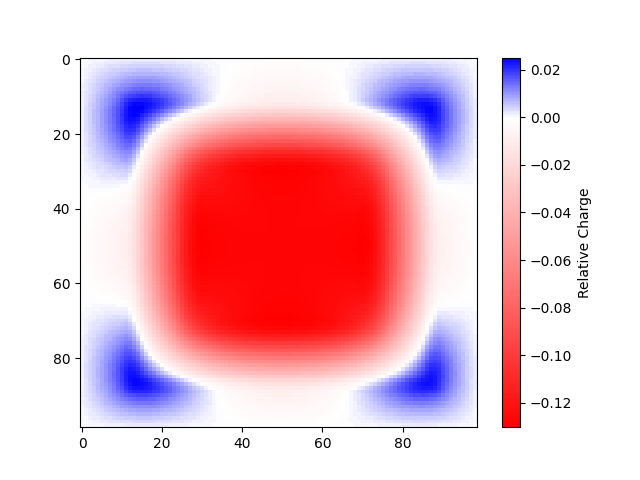

In [168]:
#plot Z bc Z is actually the answer from above cell
plt.imshow(Z, aspect = 'auto', cmap = mcolors.LinearSegmentedColormap('cmap', genDict(Z)))  
plt.colorbar(label="Relative Charge")
plt.show()